# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

from scipy.ndimage import zoom
import wandb
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime

torch.cuda.is_available()

True

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [5]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='../data', train=True, download=True, transform=transform)
ds_val = MNIST(root='../data', train=False, download=True, transform=transform)

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [45]:
# REWRITE TRAINING AND EVALUATION FUNCTIONS 
# Function to train one epoch
def train_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        opt: optim.Optimizer, 
        device="cuda"
    ):

    model.train()

    losses = []
    gts = []
    preds = []

    # Zero out the gradients
    opt.zero_grad()
    
    for (i, (xs, ys)) in enumerate(tqdm(data, desc=f"Training epoch {epoch}", leave=True)):
        # Get the input and target data and move it to the device
        xs, ys = xs.to(device), ys.to(device)

        # Zero out the gradients
        opt.zero_grad()

        # Forward pass
        logits = model(xs)

        # Get the predicted classes
        pred = torch.argmax(logits, 1)
        
        # Compute the cross entropy loss
        loss = F.cross_entropy(logits, ys)

        # Backward pass
        loss.backward()

        # Update the model parameters
        opt.step()

        # Append the loss
        losses.append(loss.item())
        preds.extend(pred.detach().cpu().numpy())
        gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)
    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()

    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
       report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "train/epoch": epoch, 
        "train/loss": loss, 
        "train/accuracy": accuracy, 
        "train_class_rep/classification_report": class_report,
        "train/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "train/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        },
        step=epoch)

    # Return the average loss, accuracy and classification report
    return loss, accuracy, class_report

# Function to evaluate one epoch
def evaluate_epoch(
        model: nn.Module, 
        data: DataLoader, 
        class_names: list, 
        epoch: int, 
        device="cuda"
    ):

    model.eval()

    losses = []
    preds = []
    gts = []
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for (_, (xs, ys)) in enumerate(tqdm(data, desc=f"Evaluating", leave=True)):
            # Get the input and target data and move it to the device
            xs, ys = xs.to(device), ys.to(device)

            # Forward pass
            logits = model(xs)

            # Compute the cross entropy loss
            loss = F.cross_entropy(logits, ys)

            # Get the predicted classes
            pred = torch.argmax(logits, 1)

            # Append the loss, predictions and ground truths
            losses.append(loss.item())
            preds.extend(pred.detach().cpu().numpy())
            gts.extend(ys.detach().cpu().numpy())

    # Compute the accuracy and classification report
    accuracy = accuracy_score(gts, preds)
    class_report = classification_report(gts, preds, zero_division=0, digits=3, output_dict=True)

    class_report_db = classification_report(gts, preds, zero_division=0, digits=3).splitlines()
    report_table = []
    for line in class_report_db[2:(len(class_names)+2)]:
        report_table.append(line.split())

    # Log the results
    loss = np.mean(losses)
    wandb.log({
        "val/epoch": epoch, 
        "val/loss": loss, 
        "val/accuracy": accuracy,
        "val_class_rep/classification_report": class_report,
        "val/confusion_matrix": wandb.plot.confusion_matrix(y_true=gts, preds=preds, class_names=class_names),
        "val/classification_report": wandb.Table(data=report_table, columns=["Class", "Precision", "Recall", "F1-score", "Support"])
        }, 
        step=epoch)
    
    return loss, accuracy, class_report

# Function to train and evaluate the model
def train_evaluate_model(
        model: nn.Module, 
        model_name: str,
        dataset_name: str,
        class_names: list,
        dl_train: DataLoader, 
        dl_test: DataLoader, 
        batch_size: int, 
        lr: int, 
        epochs: int, 
        opt: optim.Optimizer, 
        device="cuda",
    ):

    time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    test_name = model_name+"-"+time+"_"+dataset_name+"_epochs-"+str(epochs)+"_bs-"+str(batch_size)+"_lr-"+str(lr)

    wandb_init(model_name, test_name, model, dataset_name, epochs, batch_size, lr, device)

    # Train and evaluate the model
    train_results = {"loss": [], "acc": [], "class_rep": []}
    val_results = {"loss": [], "acc": [], "class_rep": []}
    max_val_acc = 0
    state_dict = None

    for epoch in range(epochs):
        # Train the model 
        train_loss, train_acc, train_class_rep = train_epoch(model, dl_train, class_names, epoch, opt, device=device)

        # Evaluate the model
        val_loss, val_acc, val_class_rep = evaluate_epoch(model, dl_test, class_names, epoch, device=device)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            state_dict = model.state_dict()
        
        # Append the results
        train_results["loss"].append(train_loss)
        train_results["acc"].append(train_acc)
        train_results["class_rep"].append(train_class_rep)
        val_results["loss"].append(val_loss)
        val_results["acc"].append(val_acc)
        val_results["class_rep"].append(val_class_rep)

    wandb.unwatch(model)
    wandb.finish()

    plot_validation_curves(train_results["loss"], val_results["loss"], train_results["acc"], val_results["acc"])

    model_states_path = "model_states/"+test_name+".pth"

    # Save the best model
    if state_dict is not None:
        torch.save(state_dict, model_states_path)
        print(f"Model saved to {model_states_path}")

# Function to initialize wandb
def wandb_init(
        model_name, 
        test_name, 
        model, 
        dataset, 
        epochs, 
        bs, 
        lr, 
        device, 
        project="DLA Assigment 1"
    ):
    # Initialize wandb
    wandb.init(
        project=project,
        name=test_name,
        # Track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset,
            "epochs": epochs,
            "batch_size": bs,
            "lr": lr,
            "optimizer": "Adam",
            "device": device.type
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss(), log="all")

# Simple function to plot the loss curve and accuracy.
def plot_validation_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.title(f'Best Validation Accuracy = {np.max(val_acc)} @ epoch {np.argmax(val_acc)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [46]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.23it/s]


Epoch 0: Train Loss: 1.8419, Train Acc: 0.3585, Val Loss: 1.2473, Val Acc: 0.6812


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Epoch 1: Train Loss: 0.8971, Train Acc: 0.7706, Val Loss: 0.6516, Val Acc: 0.8321


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.02it/s]


Epoch 2: Train Loss: 0.5764, Train Acc: 0.8465, Val Loss: 0.4875, Val Acc: 0.8699


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.71it/s]


Epoch 3: Train Loss: 0.4640, Train Acc: 0.8733, Val Loss: 0.4131, Val Acc: 0.8876


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.08it/s]


Epoch 4: Train Loss: 0.4073, Train Acc: 0.8872, Val Loss: 0.3727, Val Acc: 0.8959


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Epoch 5: Train Loss: 0.3730, Train Acc: 0.8955, Val Loss: 0.3481, Val Acc: 0.9016


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.84it/s]


Epoch 6: Train Loss: 0.3501, Train Acc: 0.9011, Val Loss: 0.3275, Val Acc: 0.9058


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.29it/s]


Epoch 7: Train Loss: 0.3333, Train Acc: 0.9057, Val Loss: 0.3151, Val Acc: 0.9093


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.25it/s]


Epoch 8: Train Loss: 0.3201, Train Acc: 0.9093, Val Loss: 0.3045, Val Acc: 0.9119


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.29it/s]


Epoch 9: Train Loss: 0.3095, Train Acc: 0.9116, Val Loss: 0.2959, Val Acc: 0.9156


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


Epoch 10: Train Loss: 0.3006, Train Acc: 0.9141, Val Loss: 0.2885, Val Acc: 0.9164


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


Epoch 11: Train Loss: 0.2928, Train Acc: 0.9159, Val Loss: 0.2826, Val Acc: 0.9195


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.87it/s]


Epoch 12: Train Loss: 0.2858, Train Acc: 0.9181, Val Loss: 0.2768, Val Acc: 0.9188


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.54it/s]


Epoch 13: Train Loss: 0.2795, Train Acc: 0.9205, Val Loss: 0.2707, Val Acc: 0.9215


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


Epoch 14: Train Loss: 0.2737, Train Acc: 0.9221, Val Loss: 0.2669, Val Acc: 0.9230


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


Epoch 15: Train Loss: 0.2685, Train Acc: 0.9233, Val Loss: 0.2620, Val Acc: 0.9247


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.09it/s]


Epoch 16: Train Loss: 0.2635, Train Acc: 0.9250, Val Loss: 0.2575, Val Acc: 0.9256


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.06it/s]


Epoch 17: Train Loss: 0.2589, Train Acc: 0.9262, Val Loss: 0.2533, Val Acc: 0.9274


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


Epoch 18: Train Loss: 0.2546, Train Acc: 0.9276, Val Loss: 0.2515, Val Acc: 0.9264


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.09it/s]


Epoch 19: Train Loss: 0.2505, Train Acc: 0.9289, Val Loss: 0.2476, Val Acc: 0.9293


train/accuracy,▁▆▇▇▇███████████████
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▅▆▇▇▇▇▇████████████
val/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
val/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,0.92892
train/epoch,19
train/loss,0.25046
val/accuracy,0.9293
val/epoch,19


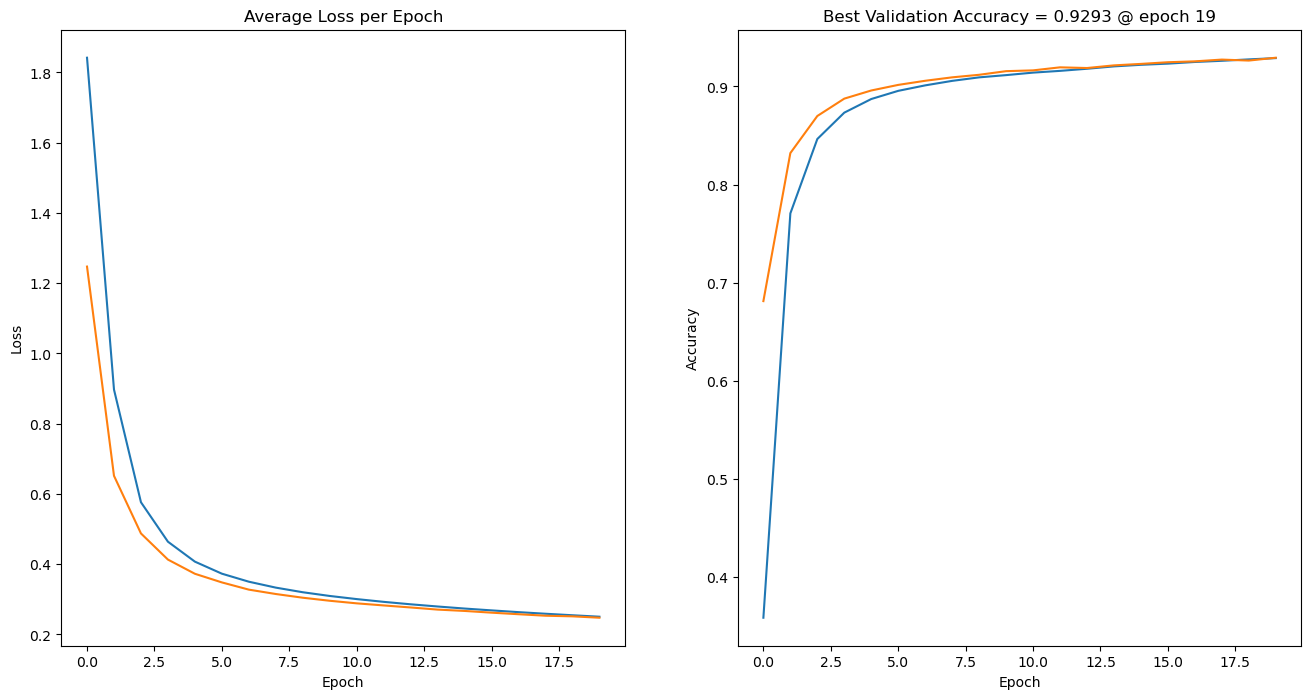

Model saved to model_states/MLP-2024-07-03_15-09-35_MNIST_epochs-20_bs-128_lr-0.0001.pth


In [47]:
# Training hyperparameters.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
train_evaluate_model(
    model=model_mlp, 
    model_name="MLP", 
    dataset_name="MNIST", 
    class_names=[str(i) for i in range(10)], 
    dl_train=dl_train, 
    dl_test=dl_val, 
    batch_size=batch_size, 
    lr=lr, 
    epochs=epochs, 
    opt=opt, 
    device=device
)

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [49]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(28*28, 128),  # First narrow layer
            nn.Linear(128, 128),  # Second narrow layer
            nn.Linear(128, 64),  # Third narrow layer
            nn.Linear(64, 64), # Fourth narrow layer
            nn.Linear(64, 10)  # Output layer
        ])
    
    def forward(self, x):
        x = x.flatten(1)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)

Using device cuda
ModuleList(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Linear(in_features=64, out_features=10, bias=True)
)


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Epoch 0: Train Loss: 0.9413, Train Acc: 0.7128, Val Loss: 0.3645, Val Acc: 0.8949


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.85it/s]


Epoch 1: Train Loss: 0.3312, Train Acc: 0.9032, Val Loss: 0.2893, Val Acc: 0.9142


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.28it/s]


Epoch 2: Train Loss: 0.2683, Train Acc: 0.9213, Val Loss: 0.2376, Val Acc: 0.9287


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Epoch 3: Train Loss: 0.2300, Train Acc: 0.9327, Val Loss: 0.2138, Val Acc: 0.9354


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.35it/s]


Epoch 4: Train Loss: 0.2011, Train Acc: 0.9412, Val Loss: 0.1858, Val Acc: 0.9436


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.13it/s]


Epoch 5: Train Loss: 0.1787, Train Acc: 0.9478, Val Loss: 0.1697, Val Acc: 0.9490


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.55it/s]


Epoch 6: Train Loss: 0.1602, Train Acc: 0.9529, Val Loss: 0.1532, Val Acc: 0.9541


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.42it/s]


Epoch 7: Train Loss: 0.1455, Train Acc: 0.9575, Val Loss: 0.1404, Val Acc: 0.9560


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Epoch 8: Train Loss: 0.1328, Train Acc: 0.9609, Val Loss: 0.1304, Val Acc: 0.9591


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.93it/s]


Epoch 9: Train Loss: 0.1213, Train Acc: 0.9643, Val Loss: 0.1236, Val Acc: 0.9613


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.45it/s]


Epoch 10: Train Loss: 0.1116, Train Acc: 0.9669, Val Loss: 0.1178, Val Acc: 0.9628


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.24it/s]


Epoch 11: Train Loss: 0.1018, Train Acc: 0.9698, Val Loss: 0.1171, Val Acc: 0.9629


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.50it/s]


Epoch 12: Train Loss: 0.0948, Train Acc: 0.9716, Val Loss: 0.1064, Val Acc: 0.9666


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.78it/s]


Epoch 13: Train Loss: 0.0877, Train Acc: 0.9739, Val Loss: 0.1073, Val Acc: 0.9663


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.55it/s]


Epoch 14: Train Loss: 0.0818, Train Acc: 0.9759, Val Loss: 0.0992, Val Acc: 0.9692


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.03it/s]


Epoch 15: Train Loss: 0.0758, Train Acc: 0.9774, Val Loss: 0.0943, Val Acc: 0.9696


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.62it/s]


Epoch 16: Train Loss: 0.0700, Train Acc: 0.9796, Val Loss: 0.0933, Val Acc: 0.9709


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.55it/s]


Epoch 17: Train Loss: 0.0655, Train Acc: 0.9810, Val Loss: 0.0920, Val Acc: 0.9707


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.74it/s]


Epoch 18: Train Loss: 0.0624, Train Acc: 0.9814, Val Loss: 0.0886, Val Acc: 0.9721


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.74it/s]


Epoch 19: Train Loss: 0.0571, Train Acc: 0.9835, Val Loss: 0.0878, Val Acc: 0.9720


train/accuracy,▁▆▆▇▇▇▇▇▇███████████
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▃▄▅▅▆▆▇▇▇▇▇█▇██████
val/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
val/loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train/accuracy,0.98345
train/epoch,19
train/loss,0.05714
val/accuracy,0.972
val/epoch,19


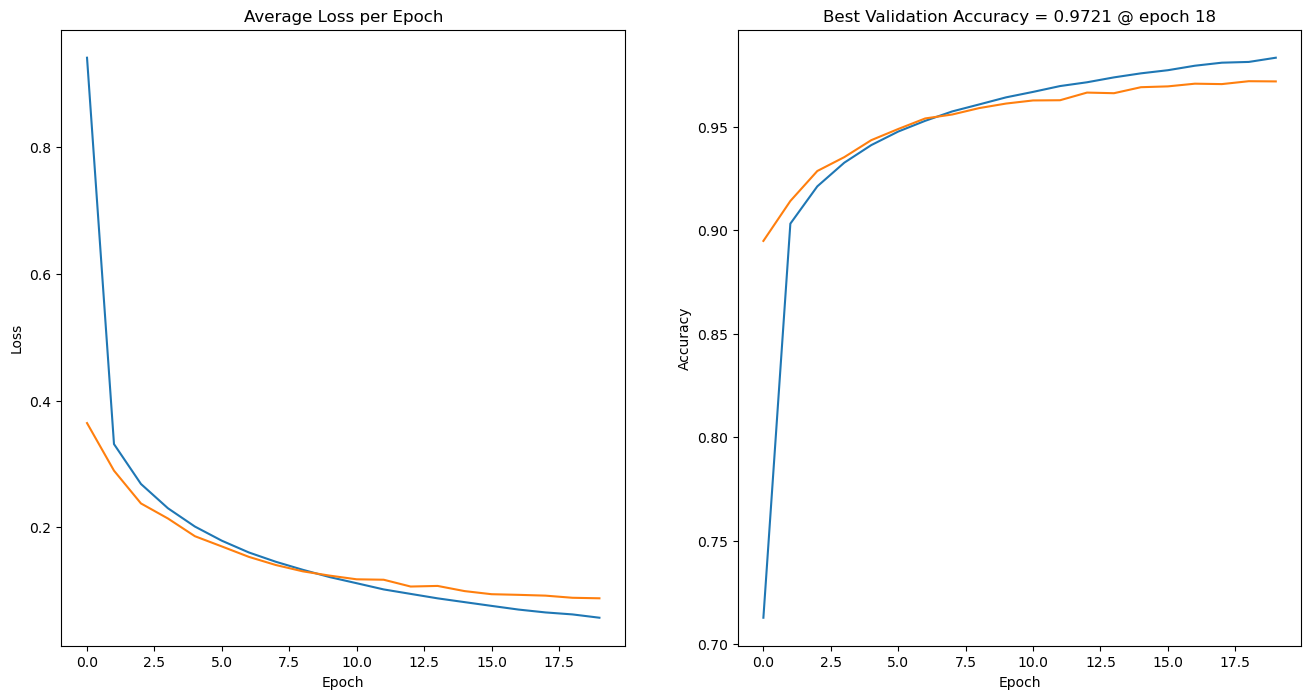

Model saved to model_states/SimpleMLP-2024-07-03_15-19-52_MNIST_epochs-20_bs-128_lr-0.0001.pth


In [50]:
# Training hyperparameters.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')
epochs = 20
lr = 0.0001
batch_size = 128

# Transform to apply to the data.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST dataset.
ds_train = MNIST(root='../data', train=True, download=True, transform=transform)
ds_val = MNIST(root='../data', train=False, download=True, transform=transform)

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)

# Instantiate model and optimizer.
model_mlp = SimpleMLP().to(device)
print(model_mlp.layers)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
train_evaluate_model(
    model=model_mlp, 
    model_name="SimpleMLP", 
    dataset_name="MNIST", 
    class_names=[str(i) for i in range(10)], 
    dl_train=dl_train, 
    dl_test=dl_val, 
    batch_size=batch_size, 
    lr=lr, 
    epochs=epochs, 
    opt=opt, 
    device=device
)

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [52]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [65]:
class NotResnet(nn.Module):
    def __init__(self, num_classes=10):
        super(NotResnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


train/accuracy,▁
train/epoch,▁
train/loss,▁
train/accuracy,0.0983
train/epoch,0
train/loss,58.25069


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch 0: Train Loss: 2.1544, Train Acc: 0.2278, Val Loss: 1.8692, Val Acc: 0.3057


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch 1: Train Loss: 1.5898, Train Acc: 0.3989, Val Loss: 1.4363, Val Acc: 0.4640


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Epoch 2: Train Loss: 1.3177, Train Acc: 0.5128, Val Loss: 1.2601, Val Acc: 0.5447


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch 3: Train Loss: 1.1151, Train Acc: 0.5970, Val Loss: 1.1986, Val Acc: 0.5849


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch 4: Train Loss: 0.9604, Train Acc: 0.6539, Val Loss: 1.2178, Val Acc: 0.6007


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch 5: Train Loss: 0.8386, Train Acc: 0.7004, Val Loss: 0.8935, Val Acc: 0.6959


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch 6: Train Loss: 0.7349, Train Acc: 0.7400, Val Loss: 0.9317, Val Acc: 0.6798


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


Epoch 7: Train Loss: 0.6529, Train Acc: 0.7700, Val Loss: 1.0094, Val Acc: 0.6826


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Epoch 8: Train Loss: 0.5673, Train Acc: 0.8022, Val Loss: 0.8569, Val Acc: 0.7253


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch 9: Train Loss: 0.5010, Train Acc: 0.8233, Val Loss: 0.8001, Val Acc: 0.7422


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Epoch 10: Train Loss: 0.4275, Train Acc: 0.8507, Val Loss: 0.9312, Val Acc: 0.7181


Evaluating: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


Epoch 11: Train Loss: 0.3652, Train Acc: 0.8705, Val Loss: 1.1422, Val Acc: 0.6879


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch 12: Train Loss: 0.3080, Train Acc: 0.8897, Val Loss: 0.8349, Val Acc: 0.7681


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch 13: Train Loss: 0.2652, Train Acc: 0.9051, Val Loss: 0.8794, Val Acc: 0.7576


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Epoch 14: Train Loss: 0.2174, Train Acc: 0.9225, Val Loss: 0.9309, Val Acc: 0.7598


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Epoch 15: Train Loss: 0.1933, Train Acc: 0.9308, Val Loss: 1.3307, Val Acc: 0.7034


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch 16: Train Loss: 0.1627, Train Acc: 0.9420, Val Loss: 1.1028, Val Acc: 0.7453


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch 17: Train Loss: 0.1464, Train Acc: 0.9484, Val Loss: 1.1953, Val Acc: 0.7540


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Epoch 18: Train Loss: 0.1307, Train Acc: 0.9545, Val Loss: 1.0447, Val Acc: 0.7714


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Epoch 19: Train Loss: 0.1055, Train Acc: 0.9628, Val Loss: 1.2573, Val Acc: 0.7607


train/accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇██████
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val/accuracy,▁▃▅▅▅▇▇▇▇█▇▇███▇████
val/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
val/loss,█▅▄▄▄▂▂▂▁▁▂▃▁▂▂▄▃▄▃▄
train/accuracy,0.9628
train/epoch,19
train/loss,0.10548
val/accuracy,0.7607
val/epoch,19


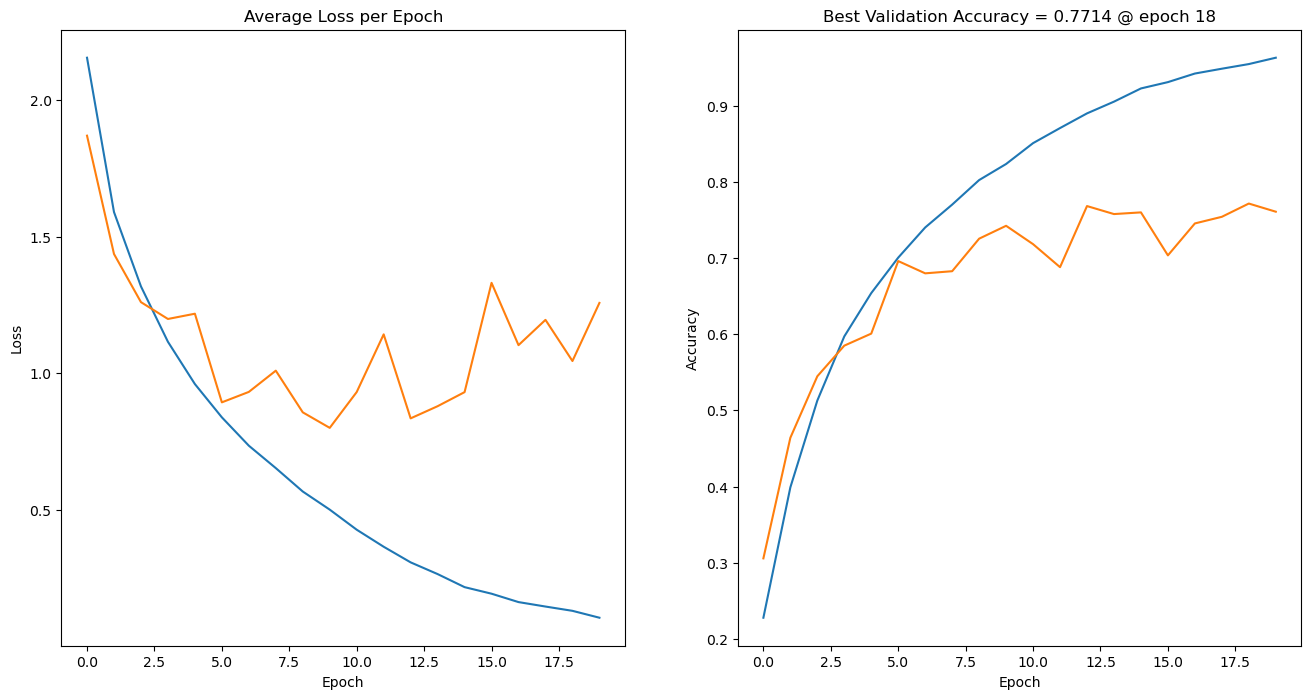

Model saved to model_states/ResidualCNN-2024-07-03_19-35-51_CIFAR10_epochs-20_bs-128_lr-0.1.pth


In [66]:
"""
TRAINING THE RESIDUAL CNN MODEL ON CIFAR10
"""

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 128
epochs = 20
lr = 0.1

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

ds_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
ds_val = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)

# Initialize the CNN model
model = NotResnet().to(device)

# Define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train and evaluate the model
train_evaluate_model(
    model=model, 
    model_name="NotResnet", 
    dataset_name="CIFAR10", 
    class_names=ds_train.classes, 
    dl_train=dl_train, 
    dl_test=dl_val, 
    batch_size=batch_size, 
    lr=lr, 
    epochs=epochs, 
    opt=optimizer, 
    device=device
)

In [58]:
# Define the basic building blocks of ResNet: Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
# The ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_blocks, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64    

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)

        self.layer1 = self._make_layer(ResidualBlock, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, num_blocks[3], stride=2)

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)    # [stride, 1, 1, ...] (num_blocks times) ensures that the first block has stride=stride
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn(self.conv1(x)))       # [batch_size, 3, 32, 32] -> [batch_size, 64, 32, 32]
        out = self.layer1(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        out = self.layer2(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        out = self.layer3(out)                     # [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        out = self.layer4(out)                     # [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        out = F.avg_pool2d(out, 4)                 # [batch_size, 512, 4, 4] -> [batch_size, 512, 1, 1] (avg_pool2d)
        out = out.view(out.size(0), -1)            # [batch_size, 512, 1, 1] -> [batch_size, 512]
        out = self.fc(out)                         # [batch_size, 512] -> [batch_size, num_classes]
        return out

Files already downloaded and verified
Files already downloaded and verified


Evaluating: 100%|██████████| 79/79 [00:30<00:00,  2.62it/s]


Epoch 0: Train Loss: 2.2151, Train Acc: 0.2079, Val Loss: 1.8703, Val Acc: 0.2836


Evaluating: 100%|██████████| 79/79 [00:28<00:00,  2.78it/s]


Epoch 1: Train Loss: 1.6586, Train Acc: 0.3599, Val Loss: 1.5338, Val Acc: 0.4224


Evaluating: 100%|██████████| 79/79 [00:30<00:00,  2.56it/s]


Epoch 2: Train Loss: 1.3699, Train Acc: 0.4924, Val Loss: 1.3335, Val Acc: 0.5187


Evaluating: 100%|██████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch 3: Train Loss: 1.1701, Train Acc: 0.5752, Val Loss: 1.2140, Val Acc: 0.5730


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.09it/s]


Epoch 4: Train Loss: 0.9716, Train Acc: 0.6523, Val Loss: 1.1800, Val Acc: 0.6018


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.09it/s]


Epoch 5: Train Loss: 0.8166, Train Acc: 0.7066, Val Loss: 0.8465, Val Acc: 0.7060


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.15it/s]


Epoch 6: Train Loss: 0.6985, Train Acc: 0.7555, Val Loss: 0.7430, Val Acc: 0.7508


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.09it/s]


Epoch 7: Train Loss: 0.5948, Train Acc: 0.7934, Val Loss: 0.7668, Val Acc: 0.7614


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.10it/s]


Epoch 8: Train Loss: 0.5183, Train Acc: 0.8196, Val Loss: 0.7118, Val Acc: 0.7664


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.11it/s]


Epoch 9: Train Loss: 0.4498, Train Acc: 0.8441, Val Loss: 0.7516, Val Acc: 0.7489


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.13it/s]


Epoch 10: Train Loss: 0.3940, Train Acc: 0.8634, Val Loss: 0.8136, Val Acc: 0.7485


Evaluating: 100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


Epoch 11: Train Loss: 0.3284, Train Acc: 0.8852, Val Loss: 0.7853, Val Acc: 0.7788


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  3.01it/s]


Epoch 12: Train Loss: 0.2856, Train Acc: 0.9001, Val Loss: 0.7362, Val Acc: 0.7898


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.14it/s]


Epoch 13: Train Loss: 0.2439, Train Acc: 0.9144, Val Loss: 0.7679, Val Acc: 0.7817


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Epoch 14: Train Loss: 0.2118, Train Acc: 0.9266, Val Loss: 0.8338, Val Acc: 0.7817


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Epoch 15: Train Loss: 0.1819, Train Acc: 0.9370, Val Loss: 0.7857, Val Acc: 0.7955


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Epoch 16: Train Loss: 0.1506, Train Acc: 0.9477, Val Loss: 0.8947, Val Acc: 0.7856


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Epoch 17: Train Loss: 0.1315, Train Acc: 0.9544, Val Loss: 0.9512, Val Acc: 0.7858


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.04it/s]


Epoch 18: Train Loss: 0.1283, Train Acc: 0.9563, Val Loss: 0.9728, Val Acc: 0.7859


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Epoch 19: Train Loss: 0.1106, Train Acc: 0.9618, Val Loss: 1.1145, Val Acc: 0.7782


train/accuracy,▁▂▄▄▅▆▆▆▇▇▇▇▇███████
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁▃▄▅▅▇▇██▇▇█████████
val/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
val/loss,█▆▅▄▄▂▁▁▁▁▂▁▁▁▂▁▂▂▃▃
train/accuracy,0.96176
train/epoch,19
train/loss,0.11063
val/accuracy,0.7782
val/epoch,19


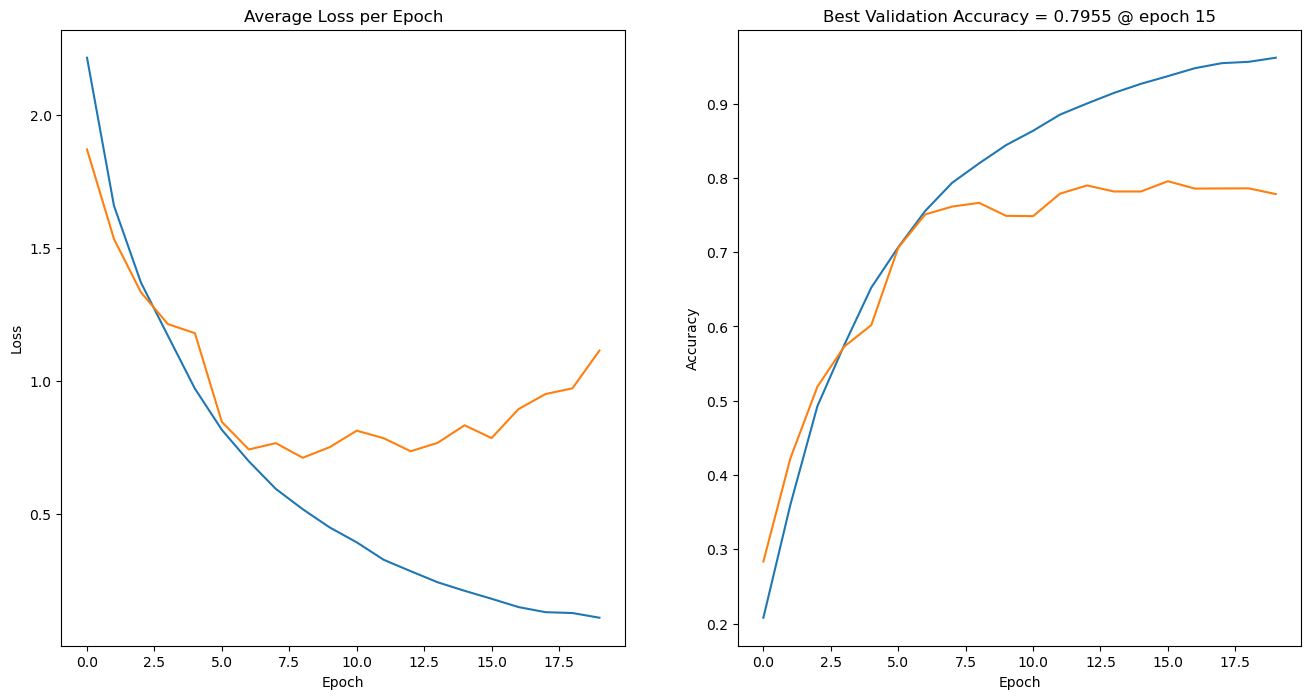

Model saved to model_states/ResNet18-2024-07-03_18-38-31_CIFAR10_epochs-20_bs-128_lr-0.1.pth


In [63]:
"""
TRAINING THE RESIDUAL CNN MODEL ON CIFAR10
"""
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 128
epochs = 20
lr = 0.1

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

ds_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
ds_val = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)

# Initialize the CNN model
model = ResNet18(num_blocks=[2, 2, 2, 2], num_classes=10).to(device)

# Define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train and evaluate the model
train_evaluate_model(
    model=model, 
    model_name="ResNet18", 
    dataset_name="CIFAR10", 
    class_names=ds_train.classes, 
    dl_train=dl_train, 
    dl_test=dl_val, 
    batch_size=batch_size, 
    lr=lr, 
    epochs=epochs, 
    opt=optimizer, 
    device=device
)